In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import entropy

In [2]:
# Load the CSV file
result_csv_path = '/opt/challenge/analyzer/malignancy/outputs/inference_results/result_5_3_0rc1.csv'
df = pd.read_csv(result_csv_path)
# df = df[df["mode"] == "val"]
df = df[df["mode"] == "test"]
df.head()

,mode,annot_ids,annotation,prob_ensemble,prob_model_0,prob_model_1,prob_model_2,prob_model_3,prob_model_4,prob_model_5,prob_model_6
0,test,102387_1_20000102,0.0,0.128476,0.114058,0.120656,0.094397,0.138930,0.131813,0.179019,0.120461
1,test,102387_1_20010102,0.0,0.120148,0.091272,0.131729,0.073752,0.128634,0.150317,0.157435,0.107897
2,test,202143_4_19990102,0.0,0.430644,0.403798,0.337562,0.492870,0.401762,0.375061,0.449837,0.553618
3,test,202143_1_19990102,0.0,0.210158,0.206628,0.178463,0.078815,0.239594,0.132958,0.228297,0.406348
4,test,202143_2_19990102,0.0,0.193479,0.155863,0.183782,0.143274,0.211339,0.133209,0.259069,0.267816


In [3]:
# Basic statistics
print("\n📝 Basic Statistics")
print(df.describe())


📝 Basic Statistics
        annotation  prob_ensemble  prob_model_0  prob_model_1  prob_model_2  \
count  6163.000000    6163.000000   6163.000000   6163.000000   6163.000000   
mean      0.090054       0.220382      0.209463      0.211229      0.205856   
std       0.286282       0.118039      0.123933      0.099750      0.185944   
min       0.000000       0.091094      0.059964      0.087413      0.022819   
25%       0.000000       0.135018      0.119860      0.138852      0.083997   
50%       0.000000       0.173551      0.161417      0.176040      0.129876   
75%       0.000000       0.271639      0.265958      0.249726      0.245322   
max       1.000000       0.663556      0.710298      0.705749      0.925531   

       prob_model_3  prob_model_4  prob_model_5  prob_model_6  
count   6163.000000   6163.000000   6163.000000   6163.000000  
mean       0.227550      0.206253      0.251860      0.230465  
std        0.089653      0.126875      0.098319      0.159830  
min        0

In [4]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]


📊 AUROC Scores (with 95% CI)
prob_model_0 AUROC: 0.9608 (95% CI: 0.9495 - 0.9722)
prob_model_1 AUROC: 0.9387 (95% CI: 0.9247 - 0.9526)
prob_model_2 AUROC: 0.9817 (95% CI: 0.9739 - 0.9896)
prob_model_3 AUROC: 0.9199 (95% CI: 0.9041 - 0.9356)
prob_model_4 AUROC: 0.9637 (95% CI: 0.9527 - 0.9746)
prob_model_5 AUROC: 0.9235 (95% CI: 0.9080 - 0.9389)
prob_model_6 AUROC: 0.9777 (95% CI: 0.9691 - 0.9864)
prob_ensemble AUROC: 0.9808 (95% CI: 0.9728 - 0.9889)


/tmp/ipykernel_17187/2983406646.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
/tmp/ipykernel_17187/2983406646.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")


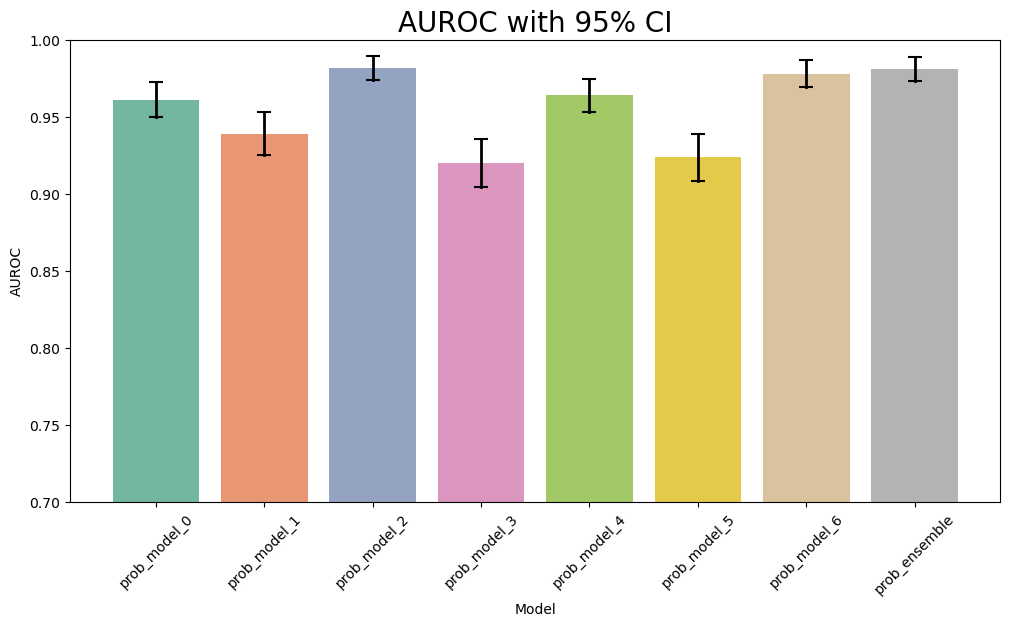

In [5]:
# Calculate AUROC scores with 95% CI
print("\n📊 AUROC Scores (with 95% CI)")
y_true = df['annotation']
auroc_scores = {}
auroc_cis = {}
for col in model_cols + [ensemble_col]:
    # Calculate AUROC
    auroc = roc_auc_score(y_true, df[col])
    auroc_scores[col] = auroc
    
    # Calculate 95% CI using DeLong method approximation
    n1 = sum(y_true == 1)
    n2 = sum(y_true == 0)
    q1 = auroc / (2 - auroc)
    q2 = 2 * (auroc ** 2) / (1 + auroc)
    se = np.sqrt((auroc * (1 - auroc) + (n1 - 1) * (q1 - auroc**2) + (n2 - 1) * (q2 - auroc**2)) / (n1 * n2))
    ci_lower = auroc - 1.96 * se
    ci_upper = auroc + 1.96 * se
    auroc_cis[col] = (ci_lower, ci_upper)
    
    print(f'{col} AUROC: {auroc:.4f} (95% CI: {ci_lower:.4f} - {ci_upper:.4f})')

# Plot AUROC with 95% CI
plt.figure(figsize=(12, 6))
auroc_df = pd.DataFrame(auroc_scores.items(), columns=["Model", "AUROC"])
auroc_df["CI Lower"], auroc_df["CI Upper"] = zip(*auroc_cis.values())
sns.barplot(x="Model", y="AUROC", data=auroc_df, ci=None, palette="Set2")
for i, (ci_lower, ci_upper) in enumerate(auroc_cis.values()):
    plt.plot([i, i], [ci_lower, ci_upper], color="black", linewidth=2)
    plt.scatter([i], [ci_lower], color="black", marker="_", s=100)
    plt.scatter([i], [ci_upper], color="black", marker="_", s=100)
plt.title("AUROC with 95% CI", fontsize=20)
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.show()


📊 Sensitivity and Specificity at 95% Thresholds
prob_model_0 - Sensitivity (95% Specificity): 0.8216, Specificity (95% Sensitivity): 0.8131
prob_model_1 - Sensitivity (95% Specificity): 0.7081, Specificity (95% Sensitivity): 0.7559
prob_model_2 - Sensitivity (95% Specificity): 0.9333, Specificity (95% Sensitivity): 0.9112
prob_model_3 - Sensitivity (95% Specificity): 0.5964, Specificity (95% Sensitivity): 0.6963
prob_model_4 - Sensitivity (95% Specificity): 0.7784, Specificity (95% Sensitivity): 0.8579
prob_model_5 - Sensitivity (95% Specificity): 0.5802, Specificity (95% Sensitivity): 0.6958
prob_model_6 - Sensitivity (95% Specificity): 0.9189, Specificity (95% Sensitivity): 0.8993
prob_ensemble - Sensitivity (95% Specificity): 0.8973, Specificity (95% Sensitivity): 0.8951


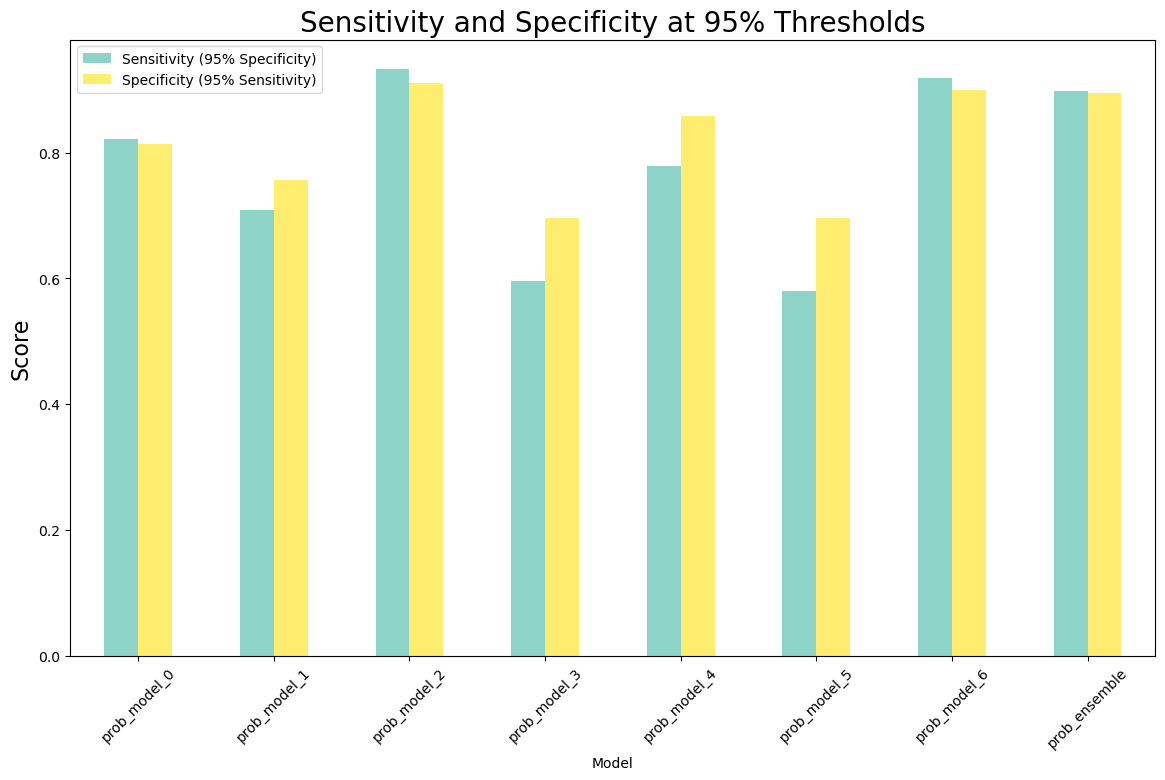

In [6]:
y_true = df['annotation']

# Sensitivity at 95% Specificity & Specificity at 95% Sensitivity
print("\n📊 Sensitivity and Specificity at 95% Thresholds")
threshold_metrics = {}
for col in model_cols + [ensemble_col]:
    fpr, tpr, thresholds = roc_curve(y_true, df[col])

    # Sensitivity at 95% Specificity
    specificity_threshold_idx = np.where(1 - fpr >= 0.95)[0]
    if len(specificity_threshold_idx) > 0:
        sensitivity_95 = max(tpr[specificity_threshold_idx])
    else:
        sensitivity_95 = np.nan

    # Specificity at 95% Sensitivity
    sensitivity_threshold_idx = np.where(tpr >= 0.95)[0]
    if len(sensitivity_threshold_idx) > 0:
        specificity_95 = max(1 - fpr[sensitivity_threshold_idx])
    else:
        specificity_95 = np.nan

    threshold_metrics[col] = (sensitivity_95, specificity_95)
    print(f"{col} - Sensitivity (95% Specificity): {sensitivity_95:.4f}, Specificity (95% Sensitivity): {specificity_95:.4f}")

# Plot Sensitivity and Specificity
threshold_df = pd.DataFrame(threshold_metrics.items(), columns=["Model", "Metrics"])
threshold_df["Sensitivity (95% Specificity)"], threshold_df["Specificity (95% Sensitivity)"] = zip(*threshold_df["Metrics"])
threshold_df.drop(columns=["Metrics"], inplace=True)
threshold_df.set_index("Model", inplace=True)
threshold_df.plot(kind="bar", figsize=(14, 8), colormap="Set3")
plt.title("Sensitivity and Specificity at 95% Thresholds", fontsize=20)
plt.xticks(rotation=45)
plt.ylabel("Score", fontsize=16)
# plt.ylim(0.2, 1.0)
plt.show()


📊 AUROC Scores
prob_model_0 AUROC: 0.9608
prob_model_1 AUROC: 0.9387
prob_model_2 AUROC: 0.9817
prob_model_3 AUROC: 0.9199
prob_model_4 AUROC: 0.9637
prob_model_5 AUROC: 0.9235
prob_model_6 AUROC: 0.9777
prob_ensemble AUROC: 0.9808


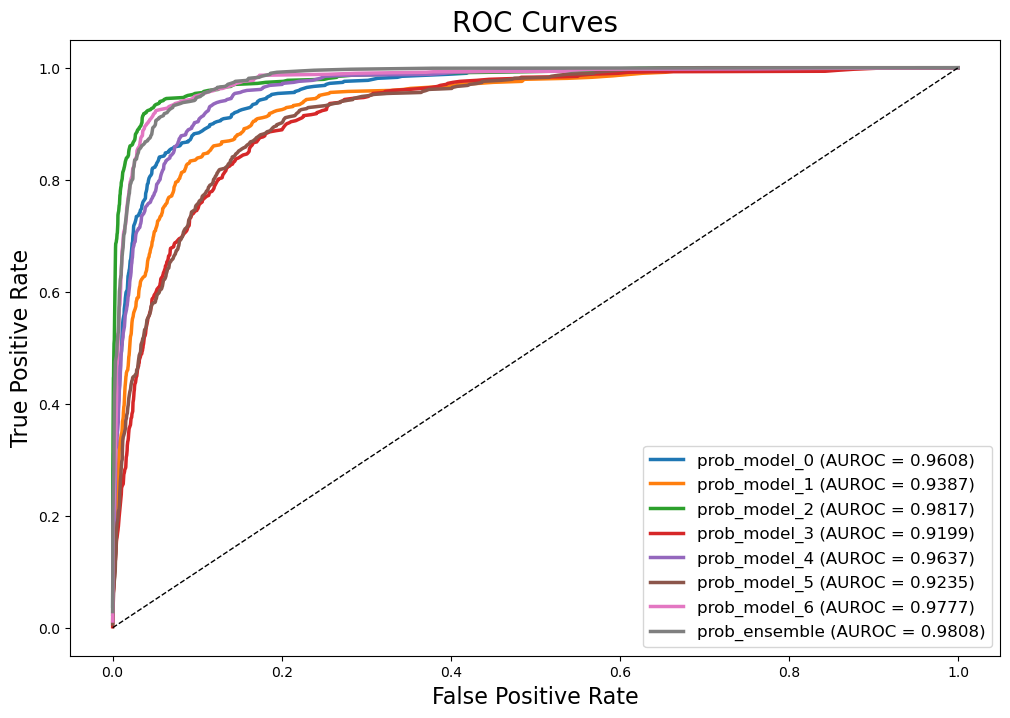

In [7]:
# Calculate AUROC scores
print("\n📊 AUROC Scores")
y_true = df['annotation']
auroc_scores = {}
for col in model_cols + [ensemble_col]:
    auroc_scores[col] = roc_auc_score(y_true, df[col])
    print(f'{col} AUROC: {auroc_scores[col]:.4f}')

# Plot ROC curves (Seaborn)
plt.figure(figsize=(12, 8))
for col in model_cols + [ensemble_col]:
    fpr, tpr, _ = roc_curve(y_true, df[col])
    sns.lineplot(x=fpr, y=tpr, label=f'{col} (AUROC = {auroc_scores[col]:.4f})', linewidth=2.5)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curves', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()


🔗 Correlation Matrix


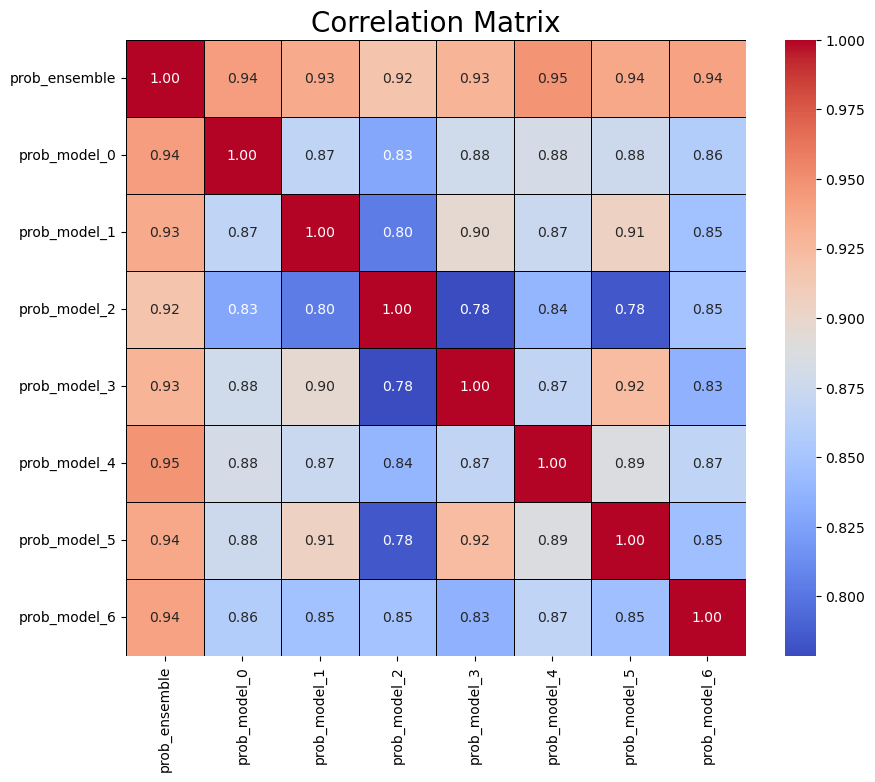

In [8]:
# Correlation matrix (Seaborn)
print("\n🔗 Correlation Matrix")
corr_matrix = df[[ensemble_col] + model_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix', fontsize=20)
plt.show()

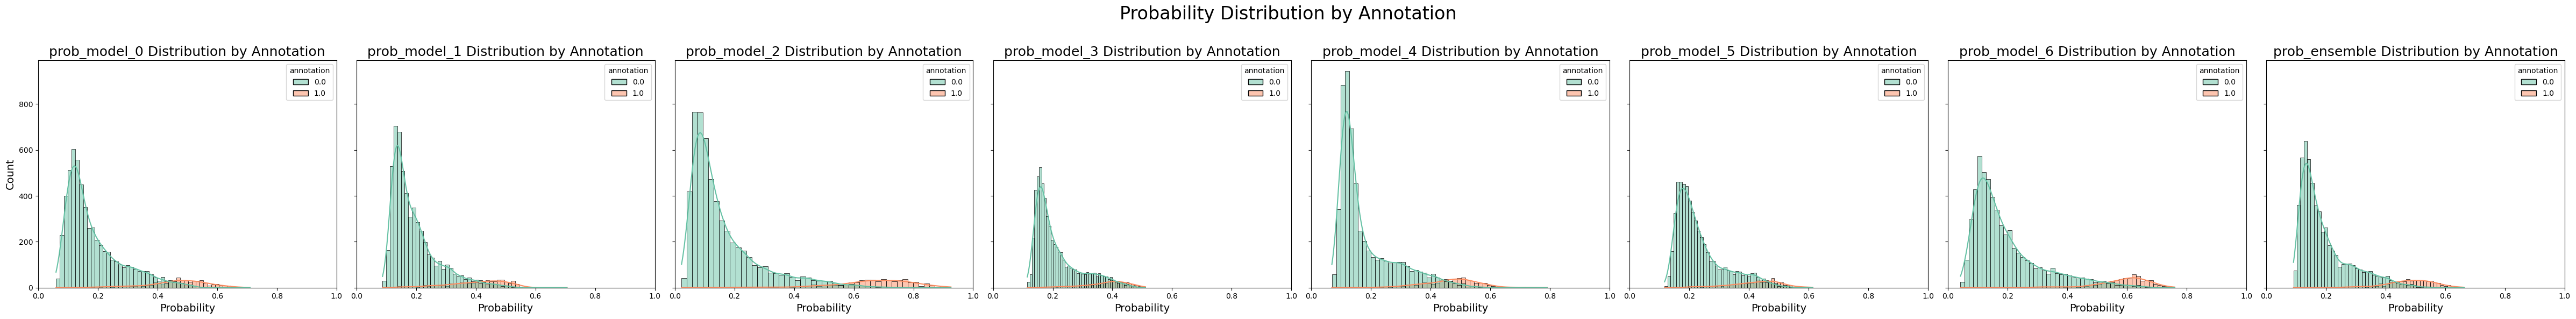

In [9]:
# Probability distribution per annotation (Seaborn, col-wise layout)
_model_cols = model_cols + [ensemble_col]
num_models = len(_model_cols)
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 6), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    sns.histplot(data=df, x=model_col, hue="annotation", bins=50, kde=True, ax=axes[i], alpha=0.5, palette="Set2")
    axes[i].set_title(f"{model_col} Distribution by Annotation", fontsize=18)
    axes[i].set_xlabel("Probability", fontsize=14)
    axes[i].set_ylabel("Count", fontsize=14)
    axes[i].set_xlim(0.0, 1.0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

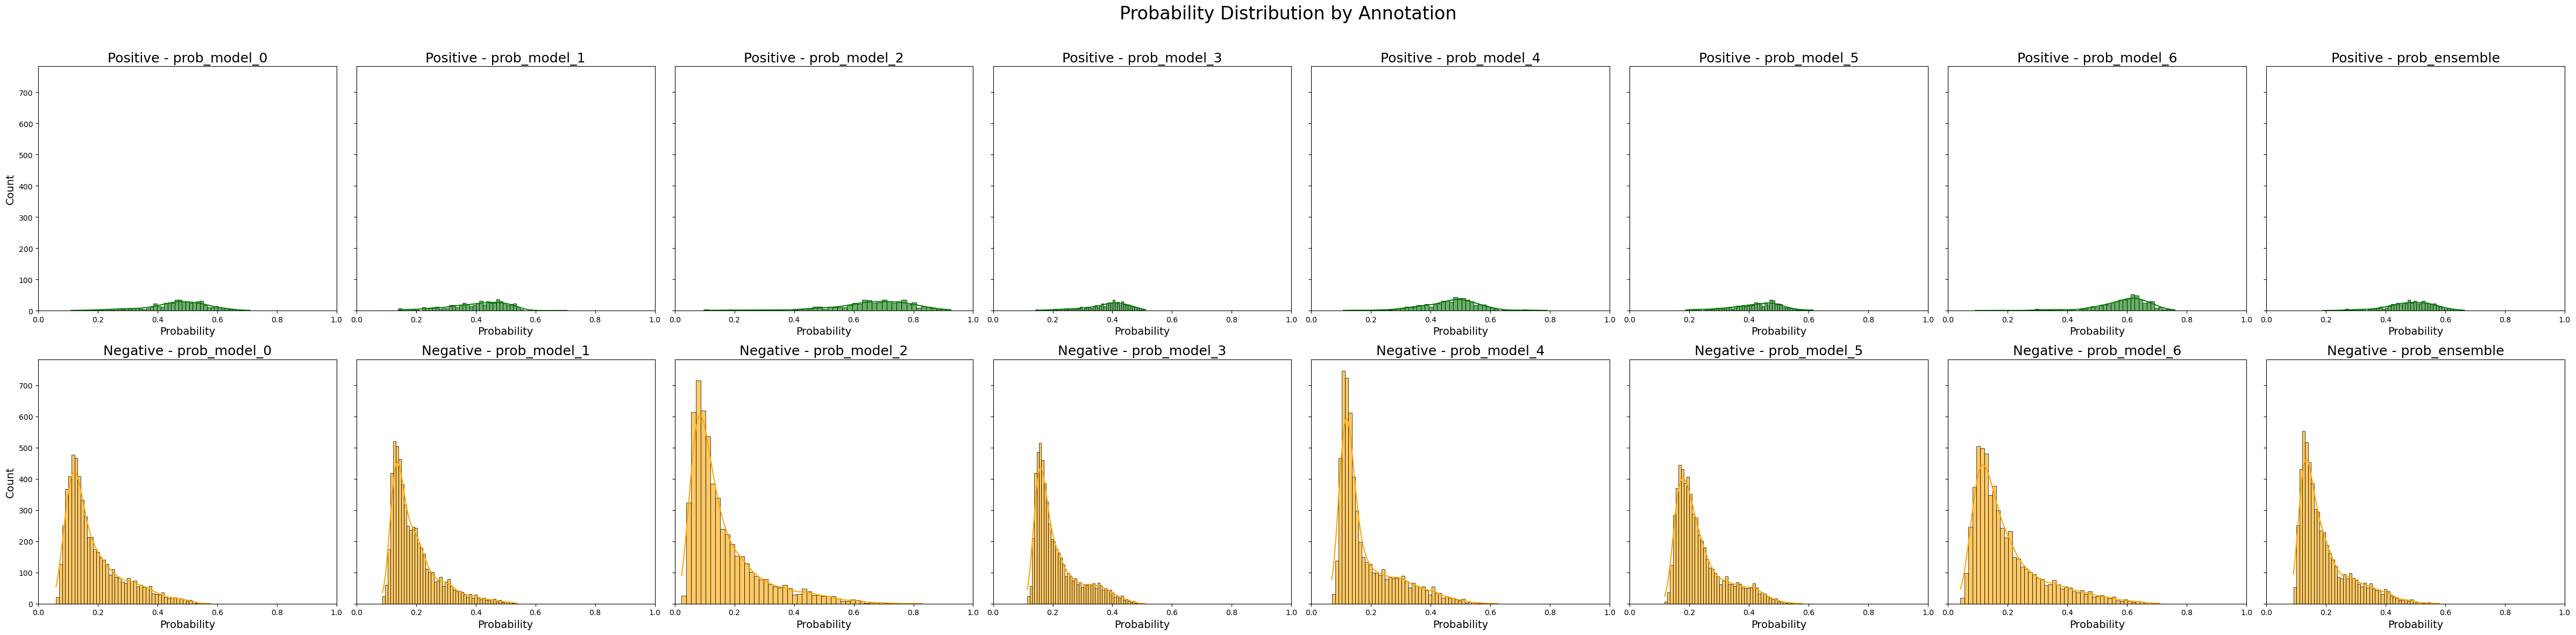

In [10]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
_model_cols = model_cols + [ensemble_col]

# Probability distribution by annotation (Seaborn, row-wise layout)
num_models = len(_model_cols)
fig, axes = plt.subplots(2, num_models, figsize=(6 * num_models, 12), sharey=True)
fig.suptitle("Probability Distribution by Annotation", fontsize=24)

for i, model_col in enumerate(_model_cols):
    # Positive annotation
    sns.histplot(data=df[df['annotation'] == 1], x=model_col, bins=50, kde=True, ax=axes[0, i], alpha=0.6, color="green")
    axes[0, i].set_title(f"Positive - {model_col}", fontsize=18)
    axes[0, i].set_xlabel("Probability", fontsize=14)
    axes[0, i].set_ylabel("Count", fontsize=14)
    axes[0, i].set_xlim(0.0, 1.0)

    # Negative annotation
    sns.histplot(data=df[df['annotation'] == 0], x=model_col, bins=50, kde=True, ax=axes[1, i], alpha=0.6, color="orange")
    axes[1, i].set_title(f"Negative - {model_col}", fontsize=18)
    axes[1, i].set_xlabel("Probability", fontsize=14)
    axes[1, i].set_ylabel("Count", fontsize=14)
    axes[1, i].set_xlim(0.0, 1.0)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


🧮 Entropy Analysis

📝 Entropy Summary
       prob_model_0  prob_model_1  prob_model_2  prob_model_3  prob_model_4  \
count   6163.000000   6163.000000   6163.000000   6163.000000   6163.000000   
mean       0.678800      0.704227      0.598946      0.742553      0.669656   
std        0.183290      0.148628      0.218385      0.131955      0.185082   
min        0.327303      0.427774      0.156990      0.513838      0.361010   
25%        0.528960      0.581223      0.416069      0.632582      0.515719   
50%        0.637688      0.671337      0.555705      0.703133      0.598065   
75%        0.835604      0.810843      0.779275      0.851470      0.842770   
max        1.000000      1.000000      0.999998      0.999994      1.000000   

       prob_model_5  prob_model_6  prob_ensemble  
count   6163.000000   6163.000000    6163.000000  
mean       0.779047      0.682729       0.707158  
std        0.125058      0.195534       0.161476  
min        0.520448      0.250661       0.440

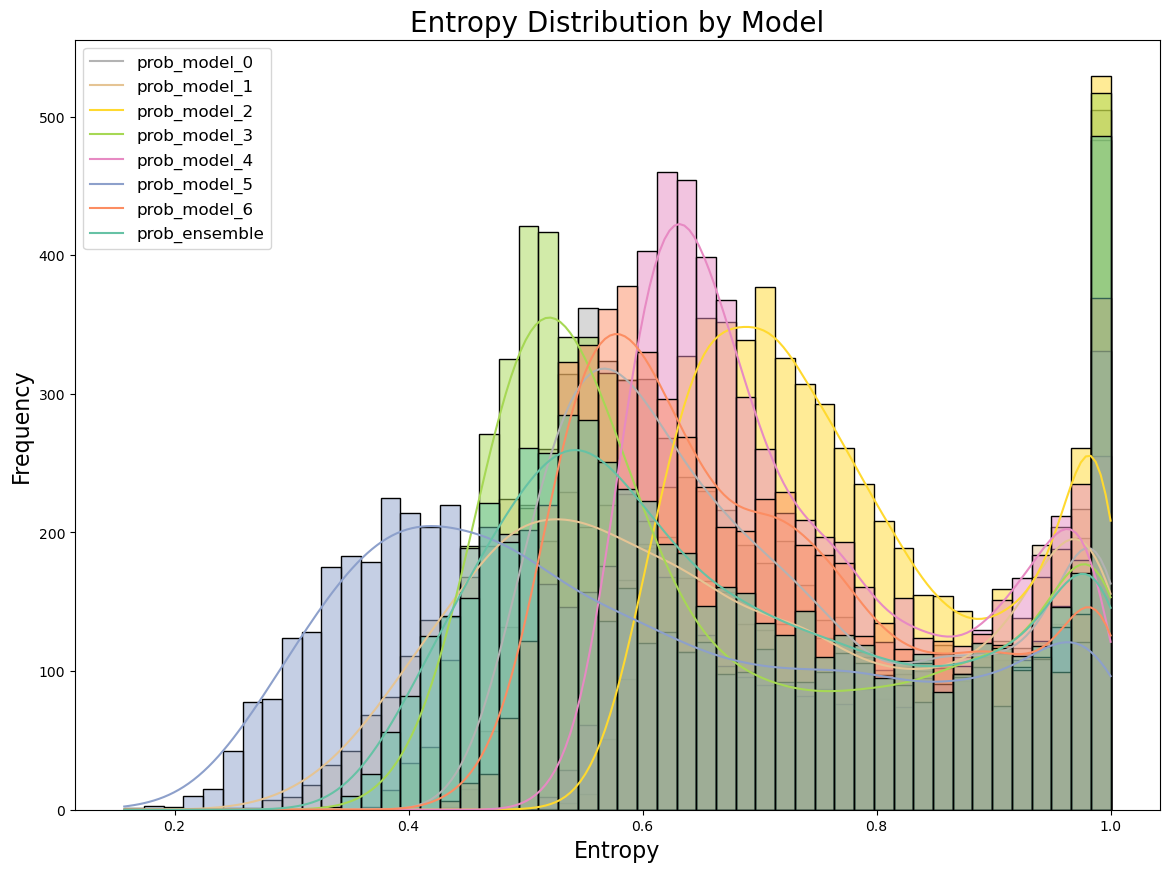

In [11]:
# Entropy calculation
print("\n🧮 Entropy Analysis")
entropy_df = pd.DataFrame()
for col in model_cols + [ensemble_col]:
    probs = df[col].values
    entropies = -(probs * np.log2(probs + 1e-10) + (1 - probs) * np.log2(1 - probs + 1e-10))
    entropy_df[col] = entropies

# Entropy summary
print("\n📝 Entropy Summary")
print(entropy_df.describe())

# Plot entropy distributions (Seaborn)
plt.figure(figsize=(14, 10))
sns.histplot(entropy_df, kde=True, bins=50, alpha=0.5, palette='Set2')
plt.title('Entropy Distribution by Model', fontsize=20)
plt.xlabel('Entropy', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(entropy_df.columns, fontsize=12)
plt.show()

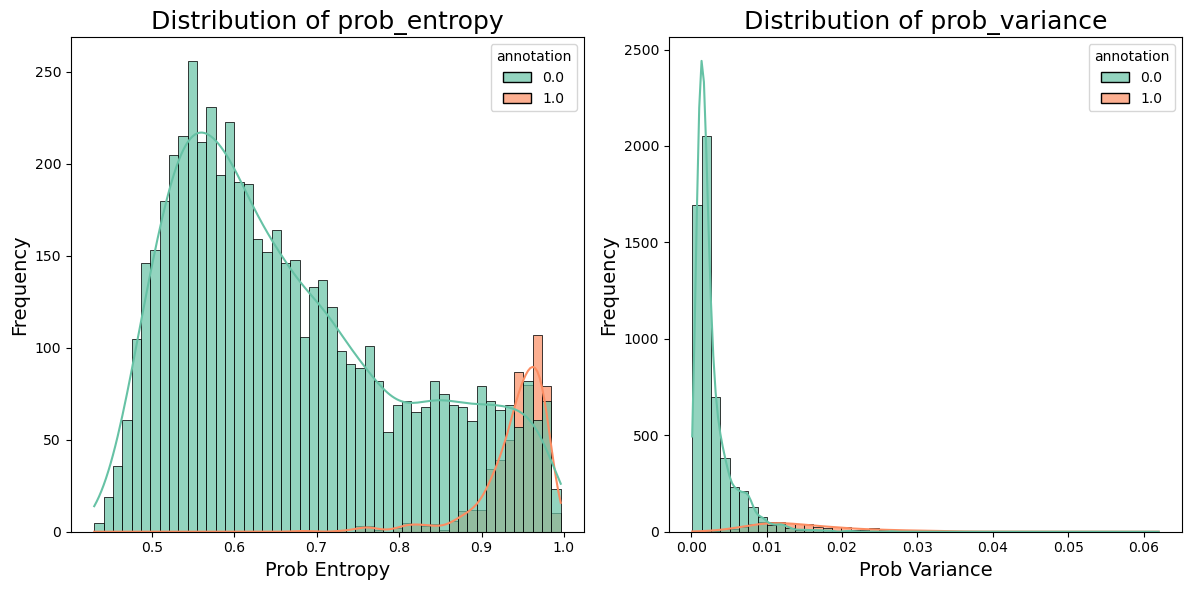


📝 Metric Summary Statistics
       prob_entropy  prob_variance
count   6163.000000    6163.000000
mean       0.693708       0.003909
std        0.154966       0.004889
min        0.430209       0.000127
25%        0.563833       0.001311
50%        0.655299       0.002036
75%        0.825641       0.004318
max        0.996118       0.062001


In [12]:
# Extract model probability columns (e.g., prob_model_0, prob_model_1, ...)
ensemble_col = 'prob_ensemble'
model_cols = [col for col in df.columns if col.startswith('prob_model_')]

# Correct entropy calculation for binary classification
binary_entropies = []
for _, row in df[model_cols].iterrows():
    entropies = - (row.values * np.log2(row.values + 1e-10) + (1 - row.values) * np.log2(1 - row.values + 1e-10))
    binary_entropies.append(np.mean(entropies))

df["prob_entropy"] = binary_entropies
df["prob_variance"] = df[model_cols].var(axis=1)

# Plot distributions
metrics = ["prob_entropy", "prob_variance"]
plt.figure(figsize=(18, 6))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x=metric, hue="annotation", bins=50, kde=True, palette="Set2", alpha=0.7)
    plt.title(f"Distribution of {metric}", fontsize=18)
    plt.xlabel(metric.replace('_', ' ').title(), fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📝 Metric Summary Statistics")
print(df[metrics].describe())

In [13]:
# Sort by entropy, variance, and CV for each annotation
sorted_positive = df[df["annotation"] == 1].sort_values(by="prob_variance", ascending=False)
sorted_negative = df[df["annotation"] == 0].sort_values(by="prob_variance", ascending=False)

# Select top N samples
N = 20
top_positive = sorted_positive.head(N)
top_negative = sorted_negative.head(N)

# Display the selected samples
print("\n🔎 Top Positive Samples (High variance)")
print(top_positive[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))

print("\n🔎 Top Negative Samples (High variance)")
print(top_negative[["annotation", "prob_entropy", "prob_variance"] + model_cols].reset_index(drop=True))


🔎 Top Positive Samples (High variance)
    annotation  prob_entropy  prob_variance  prob_model_0  prob_model_1  \
0          1.0      0.809252       0.062001      0.278842      0.230240   
1          1.0      0.828496       0.051331      0.554436      0.221177   
2          1.0      0.843429       0.048932      0.410714      0.146034   
3          1.0      0.757503       0.047804      0.191447      0.324585   
4          1.0      0.875285       0.040663      0.337055      0.301894   
5          1.0      0.894573       0.040387      0.530137      0.249097   
6          1.0      0.868716       0.038426      0.422526      0.197137   
7          1.0      0.898803       0.036749      0.545953      0.282847   
8          1.0      0.906461       0.035097      0.503441      0.343578   
9          1.0      0.889094       0.035037      0.232912      0.338406   
10         1.0      0.884554       0.034207      0.532330      0.529805   
11         1.0      0.909223       0.033992      0.297397   

In [14]:
import pymongo

from data_lake.constants import DB_ADDRESS, TARGET_COLLECTION, TARGET_DB

_CLIENT = pymongo.MongoClient(DB_ADDRESS)
_TARGET_FIELD = {}
_PROJECTION = {field: 1 for field in _TARGET_FIELD}

for _, row in top_positive.iterrows():
    query = {"annotation_id": row.annot_ids}
    nodule_candidates = [x for x in _CLIENT[TARGET_DB][TARGET_COLLECTION].find(query, _PROJECTION)]
    break


In [15]:
nodule_candidates

[{'_id': ObjectId('67f76d7650a0262ec4785bac'),
  'patient_id': 130706,
  'series_instance_uid': '1.2.840.113654.2.55.167315144178376751003685540482766432596',
  'annotation_id': '130706_1_19990102',
  'studydate': 19990102,
  'h5_path_nfs': '/team/team_blu3/lung/data/2_public/LUNA25_h5/1.2.840.113654.2.55.167315144178376751003685540482766432596.h5',
  'h5_path': '/nvme1/1_dataset/LUNA25_h5/1.2.840.113654.2.55.167315144178376751003685540482766432596.h5',
  'fold': 5,
  'label': 1,
  'age_at_study': 63,
  'gender': 'Female',
  'origin': [1475.5, -31.0, -123.0],
  'transform': [[2.0, 0.0, 0.0],
   [0.0, 0.5195310115814209, 0.0],
   [0.0, 0.0, 0.5195310115814209]],
  'spacing': [2.0, 0.5195310115814209, 0.5195310115814209],
  'resampled_spacing': [1.0, 0.67, 0.67],
  'w_coord_zyx': [1739.52, 157.07, -24.22],
  'd_coord_zyx': [132.01, 361.99956462180444, 190.13301958495157],
  'r_coord_zyx': [264.9059731543624, 280.53195223137874, 147.34378817150846],
  'fold_10': 6,
  'fold_15': 11}]